In [1]:
!pip install spacy
!python -m spacy download el_core_news_md
!pip install unidecode
!pip install optuna
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.9/42.9 MB 37.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('el_core_news_md')


In [2]:
############################################ IMPORTS ################################################
import numpy as np # linear algebra
import pandas as pd # READ CSV
import spacy
import unicodedata as ud

# utilities
import re
# plotting

from wordcloud import WordCloud
import matplotlib.pyplot as plt
# nltk
from nltk.stem import WordNetLemmatizer
# sklearn
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report
import os
from spacy.lang.el import stop_words
from sklearn.feature_extraction.text import CountVectorizer
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

import optuna
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import f1_score
from sklearn.preprocessing import label_binarize
from sklearn.datasets import make_classification
from sklearn.metrics import roc_curve, auc

In [3]:
############################################ FUNCTION ################################################
def remove_hashtags(text):
    result = re.sub(r'#\S+', '', text)
    return ' '.join(result.split())

def remove_accents(text):
    tras = {ord('\N{COMBINING ACUTE ACCENT}'):None}
    ud.normalize('NFD', text).upper().translate(tras)
    result = ud.normalize('NFD', text).translate(tras)
    return ' '.join(result.split())

def remove_numbers(text):
    result = re.sub(r'\d+', '', text)
    return ' '.join(result.split())

def remove_more_characters(text):
    result = re.sub(r'(.)\1+', r'\1', text)
    return ' '.join(result.split())

def remove_at_words(text):
    result = re.sub(r'@\S+', '', text)
    return ' '.join(result.split())

def cleaning_punctuations(text):
    translator = str.maketrans(punctuations_list, ' ' * len(punctuations_list))
    result = text.translate(translator)
    return' '.join(result.split())

def remove_url(text):
    return re.sub('((www.[^s]+)|(https?://[^s]+))',' ', text)

def create_tokenizer(text):
    return word_tokenize(text)


def remove_stopwords(text):
    words = text.split()
    not_stopwords = [word for word in words if word.lower() not in stop_words_without_accents]
    result = ' '.join(not_stopwords)
    return ' '.join(result.split())

def remove_stopwords_without_accents(text):
    words = text.split()
    not_stopwords = [word for word in words if word.lower() not in stop_words]
    result = ' '.join(not_stopwords)
    return ' '.join(result.split())

def remove_english_stopwords(text):
    words = text.split()
    not_stopwords = [word for word in words if word.lower() not in stop_words]
    result = ' '.join(not_stopwords)
    return ' '.join(result.split())

def remove_one(text):
    words = text.split()
    filtered_words = [word for word in words if len(word) != 1]
    return ' '.join(filtered_words)

In [4]:
nltk.download('punkt')
english_punctuations = string.punctuation + '«»'
punctuations_list = english_punctuations
nlp = spacy.load("el_core_news_md")
stop_words = nlp.Defaults.stop_words
nltk.download('stopwords')
english_stop_words = set(stopwords.words('english'))
stop_words_without_accents = create_tokenizer(remove_accents(' '.join(stop_words)))

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
def create_model(file_path, file):
  dataset = pd.read_csv(file_path)

  dataset. shape
  dataset.dtypes
  np.sum(dataset.isnull().any(axis=1))
  dataset['New_ID'].unique()
  dataset['New_ID'].nunique()

  dataset['Text'] = dataset['Text'].str.lower()
  dataset['Text'] = dataset['Text'].apply(remove_hashtags)
  dataset['Text'] = dataset['Text'].apply(remove_url)
  dataset['Text'] = dataset['Text'].apply(remove_numbers)
  dataset['Text'] = dataset['Text'].apply(remove_stopwords)
  dataset['Text'] = dataset['Text'].apply(remove_english_stopwords)
  dataset['Text'] = dataset['Text'].apply(remove_accents)
  dataset['Text'] = dataset['Text'].apply(remove_stopwords_without_accents)
  dataset['Text'] = dataset['Text'].apply(remove_at_words)
  dataset['Text'] = dataset['Text'].apply(cleaning_punctuations)
  dataset['Text'] = dataset['Text'].apply(create_tokenizer)

  if 'train' in file:
    dataset['Sentiment'] = dataset['Sentiment'].replace({'POSITIVE': 2, 'NEGATIVE': 0, 'NEUTRAL': 1})
    path = 'train_set_result.csv'
  elif 'valid' in file:
    dataset['Sentiment'] = dataset['Sentiment'].replace({'POSITIVE': 2, 'NEGATIVE': 0, 'NEUTRAL': 1})
    path = 'valid_set_result.csv'
  else:
    path = 'test_set_result.csv'

  return dataset

In [6]:
train_dataset = create_model('/kaggle/input/ys19-2023-assignment-2/train_set.csv', 'train')
valid_dataset = create_model('/kaggle/input/ys19-2023-assignment-2/valid_set.csv', 'valid')
train_dataset.head()
X_train = train_dataset['Text'].astype(str).tolist()
y_train = train_dataset['Sentiment']

X_validation = valid_dataset['Text'].astype(str).tolist()
y_validation = valid_dataset['Sentiment']

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import numpy as np
from gensim.models import Word2Vec

In [8]:
# Εκπαιδεύουμε το μοντέλο Word2Vec με τα δεδομένα σου
word2vec_model = Word2Vec(sentences=train_dataset['Text'].tolist(), vector_size=100, window=5, min_count=1, workers=4)
word2vec_model.save("greek_word2vec.model")

def get_embeddings(tokens, model):
    embeddings = [model.wv[word] for word in tokens if word in model.wv]
    return sum(embeddings) / len(embeddings) if embeddings else None

train_dataset['word_embeddings'] = train_dataset['Text'].apply(lambda tokens: get_embeddings(tokens, word2vec_model))
valid_dataset['word_embeddings'] = valid_dataset['Text'].apply(lambda tokens: get_embeddings(tokens, word2vec_model))

In [9]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

train_dataset = train_dataset.dropna(subset=['word_embeddings'])
valid_dataset = valid_dataset.dropna(subset=['word_embeddings'])

train_labels = train_dataset['Sentiment']
valid_labels = valid_dataset['Sentiment']

# Tensor pyTorch
train_features = torch.stack([torch.tensor(embedding) for embedding in train_dataset['word_embeddings'].dropna().tolist()])
train_labels = torch.tensor(train_dataset['Sentiment'].dropna(), dtype=torch.long)
valid_features = torch.stack([torch.tensor(embedding) for embedding in valid_dataset['word_embeddings'].dropna().tolist()])
valid_labels = torch.tensor(valid_dataset['Sentiment'].dropna(), dtype=torch.long)

# Create the train, valid loader
train_dataset = TensorDataset(train_features, train_labels)
valid_dataset = TensorDataset(valid_features, valid_labels)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

In [10]:
from sklearn.metrics import precision_recall_fscore_support


class SimpleFFNN(nn.Module):

    def __init__(self):
        super(SimpleFFNN, self).__init__()
        self.fc1 = nn.Linear(100, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 3)

        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return self.softmax(x)

# Create an instance of the model
my_model = SimpleFFNN()
loss_func = nn.BCELoss()
learning_rate = 1e-4
optimizer = torch.optim.Adam(my_model.parameters(), lr=learning_rate)


# list for train and valid

train_losses = []
val_losses = []

train_accuracies = []
val_accuracies = []

epochs = []

for epoch in range(50):
    my_model.train()
    batch_losses = []
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
      # Μετατροπή των ετικετών σε one-hot encoding
        one_hot_labels = nn.functional.one_hot(labels, num_classes=3).float()
        optimizer.zero_grad()
        outputs = my_model(inputs)

        loss = loss_func(outputs, one_hot_labels)
        loss.backward()
        optimizer.step()

        batch_losses.append(loss.item())

        # Calculate training accuracy
        _, predicted_train = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted_train == labels).sum().item()

    train_loss = sum(batch_losses) / len(train_loader)
    train_accuracy = correct_train / total_train


    # Validation
    my_model.eval()
    with torch.no_grad():
        batch_val_losses = []
        correct_val = 0
        total_val = 0

        for inputs, labels in valid_loader:
            one_hot_labels = nn.functional.one_hot(labels, num_classes=3).float()
            outputs = my_model(inputs)
            val_loss = loss_func(outputs, one_hot_labels)
            batch_val_losses.append(val_loss.item())

            # Calculate validation accuracy
            _, predicted_val = torch.max(outputs.data, 1)
            total_val += labels.size(0)

            correct_val += (predicted_val == labels).sum().item()

        val_loss = sum(batch_val_losses) / len(valid_loader)
        val_accuracy = correct_val / total_val

    # Append losses and accuracies to lists
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)


    # Print and/or plot the learning curve
    print(f"Epoch {epoch + 1}/{50} -- "
          f"Training Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
          f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

Epoch 1/50 -- Training Loss: 0.6351, Train Accuracy: 0.3549, Validation Loss: 0.6338, Validation Accuracy: 0.3710
Epoch 2/50 -- Training Loss: 0.6339, Train Accuracy: 0.3680, Validation Loss: 0.6327, Validation Accuracy: 0.3778
Epoch 3/50 -- Training Loss: 0.6334, Train Accuracy: 0.3681, Validation Loss: 0.6325, Validation Accuracy: 0.3730
Epoch 4/50 -- Training Loss: 0.6328, Train Accuracy: 0.3699, Validation Loss: 0.6318, Validation Accuracy: 0.3780
Epoch 5/50 -- Training Loss: 0.6325, Train Accuracy: 0.3696, Validation Loss: 0.6313, Validation Accuracy: 0.3700
Epoch 6/50 -- Training Loss: 0.6321, Train Accuracy: 0.3722, Validation Loss: 0.6315, Validation Accuracy: 0.3759
Epoch 7/50 -- Training Loss: 0.6319, Train Accuracy: 0.3739, Validation Loss: 0.6310, Validation Accuracy: 0.3838
Epoch 8/50 -- Training Loss: 0.6315, Train Accuracy: 0.3749, Validation Loss: 0.6308, Validation Accuracy: 0.3786
Epoch 9/50 -- Training Loss: 0.6313, Train Accuracy: 0.3751, Validation Loss: 0.6300, Va

In [11]:
dataset_test = create_model('/kaggle/input/ys19-2023-assignment-2/test_set.csv', 'test')

X_test = dataset_test['Text'].astype(str).tolist()

LEARNING CURVE

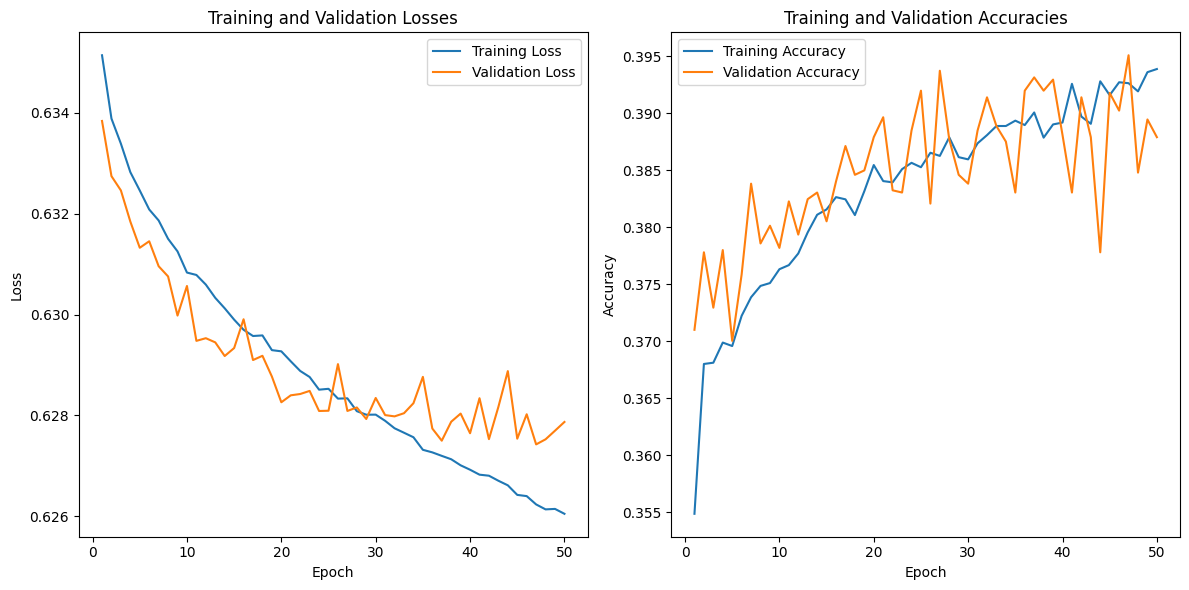

In [12]:
# the num is 50
num_epochs = 50
# create the learning curve
plt.figure(figsize=(12, 6))

# The losses
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()

# The accuracies
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracies')
plt.legend()

plt.tight_layout()
plt.show()

HYPERPARAMETER TUNING

In [13]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import optuna

def objective(trial):
    # THE HYPERPARAMETER
    hidden_size = trial.suggest_int('hidden_size', 32, 256)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)


    # Creare the FFNN MODEL
    class SimpleFFNN(nn.Module):
        def __init__(self):
            super(SimpleFFNN, self).__init__()
            self.fc1 = nn.Linear(100, hidden_size)
            self.fc2 = nn.Linear(hidden_size, 64)
            self.fc3 = nn.Linear(64, 1)
            self.sigmoid = nn.Sigmoid()

        def forward(self, x):
            x = nn.functional.relu(self.fc1(x))
            x = nn.functional.relu(self.fc2(x))
            x = self.fc3(x)
            return self.sigmoid(x)

    my_model = SimpleFFNN()
    loss_func = nn.BCELoss()
    optimizer = torch.optim.Adam(my_model.parameters(), lr=learning_rate)

    with torch.no_grad():
      correct = 0
      total = 0
      for review, sentiment in valid_loader:
          output = my_model(review)
          pred = (output > 0.5).float()
          sentiment = sentiment.unsqueeze(1)
          correct += pred.eq(sentiment).sum()
          total += sentiment.shape[0]
      validation_accuracy = correct.item() / total

    return validation_accuracy

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

best_params = study.best_params
print("Best params:", best_params)

[I 2023-12-31 21:33:53,086] A new study created in memory with name: no-name-da3ce67a-6068-4c6d-b42c-0581f6916f33
/tmp/ipykernel_19/2185564544.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
[I 2023-12-31 21:33:53,155] Trial 0 finished with value: 0.33294483294483296 and parameters: {'hidden_size': 47, 'learning_rate': 0.00013966612930342215}. Best is trial 0 with value: 0.33294483294483296.
[I 2023-12-31 21:33:53,215] Trial 1 finished with value: 0.3348873348873349 and parameters: {'hidden_size': 114, 'learning_rate': 2.5068822457941288e-05}. Best is trial 1 with value: 0.3348873348873349.
[I 2023-12-31 21:33:53,275] Trial 2 finished with value: 0.3348873348873349 and parameters: {'hidden_size': 156, 'learning_rate': 0.0013655139145155597}. Best is trial

Best params: {'hidden_size': 151, 'learning_rate': 5.717760419313267e-05}


In [14]:
import optuna
import torch
import pandas as pd
import numpy as np
from datetime import datetime

# Ορίζει το μοντέλο Net
class Net(nn.Module):
    def __init__(self, D_in, H1, H2, D_OUT):
        super(Net, self).__init__()
        self.linear1 = nn.Linear(D_in, H1)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.5)
        self.linear2 = nn.Linear(H1, H2)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.5)
        self.linear3 = nn.Linear(H2, D_OUT)

    def forward(self, x):
        x = self.linear1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        x = self.linear2(x)
        x = self.relu2(x)
        x = self.linear3(x)
        return x

# Εισάγει τα δεδομένα σας και δημιουργεί το dataset_test

def create_model2(trial):
    dataset_test['word_embeddings'] = dataset_test['word_embeddings'].fillna(method='ffill')
    D_in = dataset_test['word_embeddings'].dropna().tolist()[0].shape[0]

    D_out = 3  # Υποθέτουμε ότι έχουμε 3 κλάσεις
    return Net(D_in, trial.params['H1'], trial.params['H2'], D_out)

def log_uniform_int(min_val, max_val):
    return int(2 ** np.random.uniform(np.log2(min_val), np.log2(max_val)))

H1 = log_uniform_int(8, 256)
H2 = log_uniform_int(8, 256)


trial = optuna.trial.FrozenTrial(
    params={'H1': 64, 'H2': 128},
    distributions={'H1': optuna.distributions.IntUniformDistribution(8, 256),
                   'H2': optuna.distributions.IntUniformDistribution(8, 256)},
    value=0.1,
    state=optuna.trial.TrialState.COMPLETE,
    user_attrs={},
    system_attrs={},
    intermediate_values={},
    number=0,
    datetime_start=datetime.now(),
    datetime_complete=datetime.now(),
    trial_id=0
)

dataset_test['word_embeddings'] = dataset_test['Text'].apply(lambda tokens: get_embeddings(tokens, word2vec_model))
dataset_test['word_embeddings'] = dataset_test['word_embeddings'].fillna(method='ffill')
inputs = dataset_test['word_embeddings']


MAX_LENGTH = 100 

filtered_embeddings = [embedding for embedding in inputs if embedding is not None]
inputs_np = np.array([np.pad(embedding, (0, MAX_LENGTH - len(embedding))) if len(embedding) < MAX_LENGTH else embedding[:MAX_LENGTH] for embedding in filtered_embeddings], dtype=np.float32)
inputs_tensor = torch.tensor(inputs_np, dtype=torch.float32)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)
best_params = study.best_trial.params


best_model = create_model2(trial)

with torch.no_grad():
    outputs = best_model(inputs_tensor)
    predicted_labels = torch.argmax(outputs, dim=1)

result_df = pd.DataFrame({
'Id': dataset_test['New_ID'],
'Predicted': predicted_labels.tolist()
})
result_df['Predicted'] = result_df['Predicted'].replace({2: 'POSITIVE', 0: 'NEGATIVE', 1: 'NEUTRAL'})
result_df.to_csv('submission.csv', index=False, encoding='utf-8')

/tmp/ipykernel_19/4025053742.py:46: FutureWarning: IntUniformDistribution has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :class:`~optuna.distributions.IntDistribution` instead.
  distributions={'H1': optuna.distributions.IntUniformDistribution(8, 256),
/tmp/ipykernel_19/4025053742.py:47: FutureWarning: IntUniformDistribution has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :class:`~optuna.distributions.IntDistribution` instead.
  'H2': optuna.distributions.IntUniformDistribution(8, 256)},
[I 2023-12-31 21:33:56,917] A new study created in memory with name: no-name-d774e6fa-eea5-41b4-80c6-6bec9fe4472f
/tmp/ipykernel_19/2185564544.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., l

ROC CURVE

In [15]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

one_hot_labels = nn.functional.one_hot(labels, num_classes=3).float()

# Calculate the probabilities
with torch.no_grad():
    outputs = my_model(inputs)
    probabilities = nn.functional.softmax(outputs, dim=1).cpu().numpy()

# Calculate the rates fpr, tpr, thresholds
fpr = dict()
tpr = dict()
thresholds = dict()

#Here assigment the 3 classes
for i in range(3):
    fpr[i], tpr[i], thresholds[i] = roc_curve(one_hot_labels[:, i], probabilities[:, i])

# Calculate the ROC
roc_auc = dict()
for i in range(3):
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot
plt.figure(figsize=(8, 6))

for i in range(3):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

TypeError: linear(): argument 'input' (position 1) must be Tensor, not Series

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Assuming you have already defined your FFNN model and trained it on your data.

def confusion_matrix_model_ffnn(model, data_loader):
    model.eval()
    y_true = []
    y_pred = []

    for inputs, labels in data_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        y_true.extend(labels.tolist())
        y_pred.extend(predicted.tolist())

    cf_matrix = confusion_matrix(y_true, y_pred)

    # Negative, Neutral and Positive Categories
    categories = ['Negative', 'Neutral', 'Positive']
    group_names = ['True Neg', 'False Neutral', 'False Pos',
                   'False Neg', 'True Neutral', 'True Pos']  # ορίζουμε τις ονομασίες ομάδων

    # Plotting
    sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='d',
                xticklabels=categories, yticklabels=categories)
    plt.xlabel("Predicted values", fontdict={'size': 14}, labelpad=10)
    plt.ylabel("Actual values", fontdict={'size': 14}, labelpad=10)
    plt.title("Confusion Matrix", fontdict={'size': 18}, pad=20)
    plt.show()

# Data for valid loader
confusion_matrix_model_ffnn(my_model, valid_loader)